## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [88]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
pd.set_option("max_colwidth", None)
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head(5)


(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
# We can replace _ and source. to make column names more readable
col_regex = "^_(source.)?"
df.columns = [re.sub(col_regex, "", col) for col in df.columns]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign nan in place of blanks in the complaints column
#df[complaint_what_happened] = df[complaint_what_happened].apply()
whitespace_regex = r'^\s*$'
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x : np.nan if re.search(whitespace_regex, x) else x)
print("There are {0} complaints with Blank value".format(df["complaint_what_happened"].isnull().sum()))

There are 57241 complaints with Blank value


In [7]:
#Remove all rows where complaints column is nan
df = df[~(df["complaint_what_happened"].isnull())]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    #Make text to lower case
    text=text.lower()
    #Remove text in quare brackets
    brackets_regex = r'\[.*?\]'
    text = re.sub(brackets_regex, '', text)
    #Remove punctuations using string.punctuation
    text = ''.join(c for c in text if c not in string.punctuation)
    #Remove words containing numbers
    numbers_regex = r'[^\s]*[\d]+[^\s]*'
    text = re.sub(numbers_regex, '', text)

    return text

In [9]:
cleaned_complaints = df["complaint_what_happened"].apply(clean_text)

In [10]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [11]:
lemmatized_complaints = cleaned_complaints.apply(lemmatize_text)

In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
pd.set_option("max_colwidth", 500)
df_clean = pd.DataFrame({"complaints" : df["complaint_what_happened"], "lemmatized_complaints" : lemmatized_complaints})
df_clean.reset_index(drop = True, inplace = True)

In [13]:
df_clean

,complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx w

In [14]:
#Write your function to extract the POS tags

def pos_tag(text):
    # Tokenize the text
    doc = nlp(text)
    # Get the POS tags
    pos_tags = [(token.text, token.tag_) for token in doc]
    return pos_tags

def remove_pos_tags(text):
    #Tokenize the text
    doc = nlp(text)
    # Filter out words with the NN Tags
    filtered_tokens = [token.text for token in doc if token.tag_ == "NN"]
    # Join the filtered tokens back together
    filtered_text = " ".join(filtered_tokens)

    return filtered_text

pos_tags = df_clean["lemmatized_complaints"].apply(pos_tag)
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(lambda text: remove_pos_tags(text))  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account statement use ticket account application oblige application request application representative chase fact credit account name report credit report chase information credit report application error
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money th

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




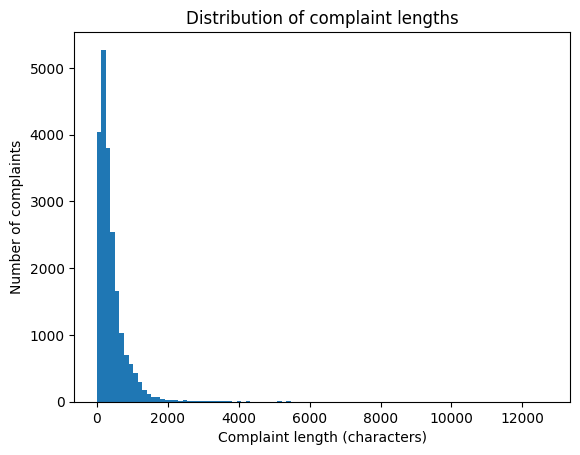

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_lengths = df_clean["complaint_POS_removed"].str.len()
# Plot the distribution of the complaint lengths
plt.hist(complaint_lengths, bins =100)
plt.xlabel("Complaint length (characters)")
plt.ylabel("Number of complaints")
plt.title("Distribution of complaint lengths")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

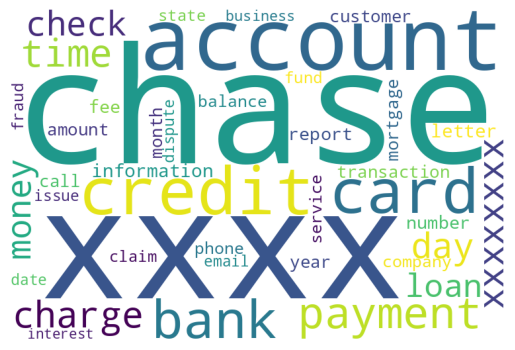

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
def create_wordcloud(text):
    # Create a WordCloud object
    word_cloud = wordcloud.WordCloud(
      max_words=40,
      background_color="white",
      width=750,
      height=500,
      random_state=100,
      collocations = False,
      stopwords=set(wordcloud.STOPWORDS)
    )

    # Generate the word cloud
    word_cloud.generate(text)

    return word_cloud

top40_word_cloud = create_wordcloud(df_clean["complaint_POS_removed"].str.cat(sep=" "))

# Display the word cloud
plt.imshow(top40_word_cloud)
plt.axis("off")
plt.show()

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
def get_top_n_grams_df(df, column, n):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer(ngram_range=(n, n))
    # Fit the vectorizer to the data frame column
    vectorizer.fit(df[column])
    # Transform the data frame column into a dense matrix
    bow = vectorizer.transform(df[column])
    # Get the counts
    counts = bow.sum(axis=0)
    words_freq = [(word, counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]


In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_uni = get_top_n_grams_df(df_clean, 'Complaint_clean',1)
top_30_uni

[('chase', 52744),
 ('xxxx', 48182),
 ('account', 46732),
 ('credit', 33464),
 ('card', 30216),
 ('bank', 21612),
 ('payment', 21159),
 ('time', 16008),
 ('charge', 14153),
 ('xxxxxxxx', 13582),
 ('day', 12971),
 ('check', 12100),
 ('money', 11953),
 ('loan', 10899),
 ('information', 9643),
 ('letter', 9598),
 ('fee', 8890),
 ('report', 8855),
 ('number', 8614),
 ('transaction', 8564),
 ('month', 8461),
 ('amount', 8422),
 ('call', 8365),
 ('year', 8289),
 ('customer', 8137),
 ('mortgage', 8072),
 ('balance', 7759),
 ('service', 7698),
 ('phone', 7570),
 ('company', 7534)]

In [21]:
#Print the top 10 words in the unigram frequency
top_30_uni[:10]

[('chase', 52744),
 ('xxxx', 48182),
 ('account', 46732),
 ('credit', 33464),
 ('card', 30216),
 ('bank', 21612),
 ('payment', 21159),
 ('time', 16008),
 ('charge', 14153),
 ('xxxxxxxx', 13582)]

In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bi = get_top_n_grams_df(df_clean, 'Complaint_clean',2)
top_30_bi

[('credit card', 12842),
 ('xxxx xxxx', 5029),
 ('credit report', 3927),
 ('customer service', 3058),
 ('account chase', 2805),
 ('chase credit', 2783),
 ('chase account', 2523),
 ('bank account', 2392),
 ('check account', 2245),
 ('account account', 2077),
 ('chase bank', 2062),
 ('debit card', 1965),
 ('checking account', 1847),
 ('chase card', 1727),
 ('credit score', 1707),
 ('account xxxx', 1687),
 ('phone call', 1650),
 ('number xxxx', 1641),
 ('xxxx credit', 1620),
 ('card account', 1608),
 ('xxxx chase', 1601),
 ('card chase', 1481),
 ('xxxx account', 1413),
 ('account credit', 1388),
 ('chase xxxx', 1315),
 ('interest rate', 1288),
 ('business day', 1253),
 ('money account', 1252),
 ('account bank', 1243),
 ('phone number', 1240)]

In [23]:
#Print the top 10 words in the bigram frequency
top_30_bi[:10]

[('credit card', 12842),
 ('xxxx xxxx', 5029),
 ('credit report', 3927),
 ('customer service', 3058),
 ('account chase', 2805),
 ('chase credit', 2783),
 ('chase account', 2523),
 ('bank account', 2392),
 ('check account', 2245),
 ('account account', 2077)]

In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_tri = get_top_n_grams_df(df_clean, 'Complaint_clean',3)
top_30_tri

[('chase credit card', 1881),
 ('credit card account', 1066),
 ('credit card company', 981),
 ('xxxx credit card', 786),
 ('xxxx xxxx xxxx', 784),
 ('credit card chase', 683),
 ('inquiry credit report', 488),
 ('credit card credit', 478),
 ('credit card xxxx', 398),
 ('account credit card', 395),
 ('chase customer service', 385),
 ('credit reporting agency', 382),
 ('charge credit card', 372),
 ('chase checking account', 371),
 ('card credit card', 358),
 ('credit report credit', 347),
 ('customer service representative', 339),
 ('credit reporting act', 338),
 ('credit card payment', 293),
 ('chase bank account', 278),
 ('credit card charge', 269),
 ('account number xxxx', 264),
 ('account credit report', 258),
 ('bank credit card', 256),
 ('chase card service', 255),
 ('chase auto finance', 253),
 ('victim identity theft', 251),
 ('account chase account', 250),
 ('credit card balance', 250),
 ('credit card card', 238)]

In [26]:
#Print the top 10 words in the trigram frequency
top_30_tri[:10]

[('chase credit card', 1881),
 ('credit card account', 1066),
 ('credit card company', 981),
 ('xxxx credit card', 786),
 ('xxxx xxxx xxxx', 784),
 ('credit card chase', 683),
 ('inquiry credit report', 488),
 ('credit card credit', 478),
 ('credit card xxxx', 398),
 ('account credit card', 395)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [28]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account statement

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = "english")


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix= tf_idf_vectorizer.fit_transform(df_clean['Complaint_clean'])

In [37]:
vocab = np.array(tf_idf_vectorizer.get_feature_names_out())
print("Vocabulary size :",len(vocab))

Vocabulary size : 6779


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,purchase,offer,application,service,time
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,statement,date,letter
Topic 4,report,inquiry,credit,company,information,reporting,debt,identity,account,theft,score,letter,date,file,creditor
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,service,email,refund,time,company,day


All the topics are Valid here, lets repeat the process by increasing the num_topics & validate.

In [39]:
num_topics = 6

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transaction,transfer,customer
Topic 2,card,credit,chase,balance,account,limit,year,score,point,purchase,offer,time,service,application,month
Topic 3,payment,balance,month,fee,statement,day,time,credit,chase,auto,date,pay,account,report,year
Topic 4,report,inquiry,credit,company,information,reporting,identity,debt,account,theft,score,date,letter,dispute,file
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,rate,time,document,foreclosure,house,sale,request
Topic 6,charge,dispute,transaction,fee,chase,merchant,claim,fraud,purchase,service,refund,statement,email,day,company


Topic 6 looks like a repeated topic.

In [41]:
num_topics = 7

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,bank,money,checking,number,information,branch,reason,balance,transfer,business,fund,letter,fraud
Topic 2,card,credit,chase,balance,limit,score,point,year,purchase,offer,application,service,time,company,month
Topic 3,payment,balance,month,fee,statement,day,time,credit,auto,date,chase,pay,error,mortgage,report
Topic 4,report,inquiry,credit,company,reporting,information,identity,debt,score,theft,date,dispute,file,proof,creditor
Topic 5,loan,mortgage,chase,home,modification,property,year,letter,rate,document,time,foreclosure,house,sale,request
Topic 6,charge,transaction,dispute,fee,chase,merchant,claim,fraud,purchase,service,refund,email,day,statement,time
Topic 7,check,bank,money,fund,deposit,day,branch,cash,claim,chase,hold,business,customer,atm,person


Topic 6 & 7 looks like a repeated topic.

At max 5 topics can be extracted with this dataset.

In [43]:
num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(doc_term_matrix)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,month,purchase,offer,application,service,time
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,statement,date,letter
Topic 4,report,inquiry,credit,company,information,reporting,debt,identity,account,theft,score,letter,date,file,creditor
Topic 5,charge,dispute,transaction,chase,fee,merchant,claim,fraud,purchase,service,email,refund,time,company,day


#### Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

In [56]:
document_topic = pd.DataFrame(W, columns = [f'Topic {i + 1}' for i in range(num_topics)])
document_topic["Dominant_Topic"] = document_topic.apply(lambda x : np.argmax(x), axis = 1)
document_topic.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Dominant_Topic
0,0.023602,0.002246,0.017313,0.014685,0.010578,0
1,0.007765,0.015157,0.002285,0.001544,0.006792,1
2,0.000000,0.034254,0.000000,0.048692,0.002565,3
3,0.018186,0.032782,0.005221,0.051606,0.006993,3
4,0.071107,0.000674,0.007544,0.000000,0.010458,0


In [57]:
df_clean['Topic'] = document_topic["Dominant_Topic"]
df_clean.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
15685,"I purchased a new XXXX with financing through XXXX XXXX XXXX ( JPMorgan Chase Bank, N.A. ). Unfortunately, Im unable to interact with Chase as they have incorrect information on file and are unable to verify my identity. They do not recognize any of the information I provided on the loan application, nor the information on the bill THEY sent me. Ive made multiple phone calls and have asked to speak with a manager multiple times ; however, after spending 1-2 hours on hold never reached anyone...",I purchase a new xxxx with financing through xxxx xxxx xxxx jpmorgan chase bank na unfortunately I m unable to interact with chase as they have incorrect information on file and be unable to verify my identity they do not recognize any of the information I provide on the loan application nor the information on the bill they send I I ve make multiple phone call and have ask to speak with a manager multiple time however after spend hour on hold never reach anyone willing to assist I al...,xxxx financing chase information file identity information loan application information bill phone call manager time spend hour hold anyone ability bill,financing chase information file identity information loan application information bill phone call manager time spend hour hold anyone ability bill,2
17659,"I am writing to you regarding a transaction dispute that Chase ( specifically Chase Sapphire Preferred ) could not resolve and dragged on for almost 6 months. Even though I provided all needed evidence to Chase that this transaction was for damage to a rental car that I did not cause, they decided ( without any evidence from the company that there was such damage ) to end the dispute in favor of the merchant. This was regarding a dispute with XXXX XXXX in XXXX for the transactions on XX/XX/X...",I be write to you regard a transaction dispute that chase specifically chase sapphire prefer could not resolve and drag on for almost month even though I provide all need evidence to chase that this transaction be for damage to a rental car that I do not cause they decide without any evidence from the company that there be such damage to end the dispute in favor of the merchant this be regard a dispute with xxxx xxxx in xxxx for the transaction on xxxxxxxx for xxxx and on xxxxxxx...,transaction dispute chase sapphire month evidence transaction damage car evidence company damage dispute favor merchant dispute transaction xxxxxxxx car wedding friend car morning flight car night employee desk inform problem garage key box week car accident scratch garage chase picture attach picture company tourist charge cost base review xxxx branch xxxx customer target car travel agency country car communication anything car charge sum statement company time summer claim charge chase mon...,transaction dispute chase sapphire month evidence transaction damage car evidence company damage dispute favor merchant dispute transaction car wedding friend car morning flight car night employee desk inform problem garage key box week car accident scratch garage chase picture attach picture company tourist charge cost base review branch customer target car travel agency country car communication anything car charge sum statement company time summer claim charge chase month letter chase ...,4
14110,On XX/XX/XXXX I sent XXXX XXXX a XXXX payment for {$740.00} for rent. A week later my room mate tells me he hadnt received the payment. I went in to my Chase account using the App and that is when I noticed that one of the numbers to the phone number was wrong. I immediately called the back of my debit card and spoke to a representative where I filed my claim. I was told that they would let me know what the outcome would be in about 10 days. They asked me if I knew the person who had receive...,on xxxxxxxx I send xxxx xxxx a xxxx payment for for rent a week later my room mate tell I he have not receive the paym

#### Print the first 5 Complaint for each of the Topics

Validating the document topic mapping

In [58]:
df_clean.groupby('Topic').head(5).sort_values(by = "Topic")

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
10,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Po...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I that the fund would post but they may take an additional busine...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund bank teller chase inform check business day fund account bind fee rent car payment notice thing peace mind fact chase situation bank teller inform account look right account time protocol past notice form document shore notice thing pe...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund bank teller chase inform check business day fund account bind fee rent car payment notice thing peace mind fact chase situation bank teller inform account look right account time protocol past notice form document shore notice thing pe...,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I ch

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [59]:
topic_name_mapping = {0 : "Bank Account services", 1 : "Credit card/Prepaid card", 2 : "Mortgage/Loan", 3 : "Others", 4 : "Theft/Dispute Reporting"}
df_clean['Topic'] = df_clean['Topic'].map(topic_name_mapping)
df_clean.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
7532,"I went to a car dealership. They applied loans for me to many banks and credit unions without my authorization. So, I got unauthorized inquiries on my credit reports",I go to a car dealership they apply loan for I to many bank and credit union without my authorization so I get unauthorized inquiry on my credit report,car dealership loan bank credit union authorization inquiry credit report,car dealership loan bank credit union authorization inquiry credit report,Others
7333,"We purchased a puppy from a man in Texas on XX/XX/XXXX via the internet, we had contact through email. We live in Indiana, and he was supposed to ship the puppy to us the next day through ( XXXX XXXX ) which is also a scam website and company. We paid {$740.00} to the man and that included the shipping fees, we XXXX 'd the money through our Chase account to the man and never received our product because he was a scammer. The next day the "" shipping company '' tried to scam more money out o...",we purchase a puppy from a man in texas on xxxxxxxx via the internet we have contact through email we live in indiana and he be suppose to ship the puppy to we the next day through xxxx xxxx which be also a scam website and company we pay to the man and that include the shipping fee we xxxx d the money through our chase account to the man and never receive our product because he be a scammer the next day the shipping company try to scam more money out of we the man have since rem...,puppy man internet contact email puppy day scam website company man shipping fee xxxx money chase account man product scammer day shipping company money man website xxxx shipping company website bank chase account call chase money protection fund party transaction protection money debit card check money mind app tie bank account chase claim fraud claim fraud protection investigation team claim loss chase app money account situation,puppy man internet contact email puppy day scam website company man shipping fee money chase account man product scammer day shipping company money man website shipping company website bank chase account call chase money protection fund party transaction protection money debit card check money mind app tie bank account chase claim fraud claim fraud protection investigation team claim loss chase app money account situation,Bank Account services
5747,"To Whom It May Concern, We continue to dispute the validity of the fraud charges that occurred on XX/XX/XXXX. We request that the charges of {$41.00} and {$2100.00} be credited to our current Chase Sapphire account as soon as possible without any punitive actions. \n\nThese charges were reported to Chase Security within minutes of the alert appearing on our mobile device on XX/XX/XXXX. \n\nOn XX/XX/XXXX we received written notice that the fraud charges had again been applied to our Sapphire ...",to whom it may concern we continue to dispute the validity of the fraud charge that occur on xxxxxxxx we request that the charge of and be credit to our current chase sapphire account as soon as possible without any punitive action \n\n these charge be report to chase security within minute of the alert appear on our mobile device on xxxxxxxx \n\n on xxxxxxxx we receive write notice that the fraud charge have again be apply to our sapphire credit card account for the reason you receive b...,concern validity fraud charge xxxxxxxx charge credit chase sapphire action charge report security minute alert device xxxxxxxx notice fraud charge sapphire credit card account reason benefit transaction finding investigation benefit merchant xxxx contact chase fraud time phone time return call day investigator escalation team credit dispute charge none promise,concern validity fraud charge charge credit chase sapphire action charge report security minute alert device notice fraud charge sapphire credit card account reason benefit transaction finding inves

## Supervised model to predict any new complaints to the relevant Topics.

We have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [60]:
topic_name_idx_mapping = {"Bank Account services" : 0, "Credit card/Prepaid card" : 1, "Mortgage/Loan" : 2 , "Others" : 3, "Theft/Dispute Reporting" : 4}
df_clean['Topic'] = df_clean['Topic'].map(topic_name_idx_mapping)
df_clean.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
20113,Received a communication from Chase stating as a new benefit they will reimburse cost of XXXX precheck registration. \nI live 170 miles from nearest registration site. Happened to be in XXXX XX/XX/XXXX. Which saved me a 340 mile round trip. When I received my statement with no credit was toldI should have read the fine print benefit doesn't start until XX/XX/XXXX!! \nVery misleading practice.,receive a communication from chase state as a new benefit they will reimburse cost of xxxx precheck registration \n I live mile from near registration site happen to be in xxxx xxxxxxxx which save I a mile round trip when I receive my statement with no credit be toldi should have read the fine print benefit do not start until xxxxxxxx \n very misleading practice,communication chase state benefit cost precheck registration mile registration site mile round trip statement credit print benefit xxxxxxxx practice,communication chase state benefit cost precheck registration mile registration site mile round trip statement credit print benefit practice,1
15820,I STOP BY BY A CHASE BANK > ASKING A BANKER THAT I WOULD LIKE TO BE REMOVED OFF MY WIFE 'S CHASE CREDIT CARDS AS AUTH. USER > IT EFFECTS MY UDR % FICO SCORE. CHASE SLATE : XXXX CHASE XXXX : XXXX CHASE XXXX : XXXX I AM JUST AN AUTH. USER ON HER CREDIT CARDS. SHE MAINTAINS GOOD STANDING ON ALL HER CREDIT CARDS. BUT FOR SOME REASON HER BALANCES ON HER CHASE CREDIT CARDS ARE EFFECTING MY FICO SCORE. HER FICO SCORE IS GOOD BUT FOR SOME REASON HER CHASE ACCTS ARE EFFECTING MY SCORE.,I stop by by a chase bank ask a banker that I would like to be remove off my wife s chase credit card as auth user it effect my udr fico score chase slate xxxx chase xxxx xxxx chase xxxx xxxx I be just an auth user on her credit card she maintain good stand on all her credit card but for some reason her balance on her chase credit card be effect my fico score her fico score be good but for some reason her chase acct be effect my score,chase bank banker wife chase credit card udr score chase slate xxxx xxxx user credit card stand credit card reason balance chase credit card fico fico score reason chase acct score,chase bank banker wife chase credit card udr score chase slate user credit card stand credit card reason balance chase credit card fico fico score reason chase acct score,1
4669,"Name : XXXX XXXX Phone # : XXXX RE : Credit Card Breach at Chase Financial Services. \n\nDetail Events : -Received fraud alert from Chase on Wednesday, XX/XX/2019 regarding card ending in XXXX. \n-Chase closed card ending in XXXX and issued card ending in XXXX following confirmation that I did not approve the authorization from a merchant named "" XXXX '' in the amount of {$0.00}. \n-The card was mailed overnight and received on Friday, XX/XX/2019 via XXXX. \n-I received the card on Friday ev...",name xxxx xxxx phone xxxx re credit card breach at chase financial service \n\n detail event receive fraud alert from chase on wednesday regard card end in xxxx \n chase closed card end in xxxx and issue card end in xxxx follow confirmation that I do not approve the authorization from a merchant name xxxx in the amount of \n the card be mail overnight and receive on friday via xxxx \n I receive the card on friday evening and add it to my wallet the card do not leave my ho...,name xxxx credit card breach service detail event fraud alert chase regard card end card end issue card end confirmation authorization merchant name xxxx amount card mail card evening wallet card house call chase fraud team message card call phone end xxxx chase card house information breach chase information call card end card mail xxxx,name credit card breach service detail event fraud alert chase regard card end card end issue card end confirmation authorization merchant name amount card mail card evening wallet card house call chase fraud team message card call phone end chase card ho

In [63]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help,0
10,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Po...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually be close I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return the bank associate and the customer service representative assure I that the fund would post but they may take an additional busine...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund bank teller chase inform check business day fund account bind fee rent car payment notice thing peace mind fact chase situation bank teller inform account look right account time protocol past notice form document shore notice thing pe...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund post look account fund statement call business day state date fund bank teller chase inform check business day fund account bind fee rent car payment notice thing peace mind fact chase situation bank teller inform account look right account time protocol past notice form document shore notice thing pe...,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I ch

In [67]:
#Keep the columns "complaints" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaints", "Topic"]]
training_data.sample(5)

,complaints,Topic
24,"I made a purchase of {$260.00} on XX/XX/XXXX. I made payments of {$160.00} on XX/XX/XXXX and {$260.00} on XX/XX/XXXX. The minimum payment was {$140.00}. The closing date was XX/XX/XXXX ( please see attached statement ). That statement ( XX/XX/XXXX ) shows that I had an outstanding purchase balance of {$230.00} on XX/XX/XXXX. I have enclosed the previous months statement to show that there were NO other purchases prior to the one on XX/XX/XXXX. \nHowever, when I got the XXXX statement, it sho...",2
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Po...,0
22,My roommate was stealing my Chase debit card and drivers license ; pretending to be me and withdrawing money from my account. He admitted that he figured out my pin because it happens to be the same as my phone password. \n\nHe also admitted that he would sneak into my room while I was sleeping and put the card back before I woke up. \n\nHe apologized but says he spent the money. I tried to dispute this with Chase but they claim that since my debit card PIN number was used that they cant pro...,1
10,mishandling of this account by Chase auto and XXXX.,0
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0


In [68]:
training_data

,complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",3
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",3
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,0
5,Can you please remove inquiry,3
6,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Po...,0
7,"During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, my request for payment extension is granted. I have never been delinquent with my auto loan payment. However, On XX/XX/2019 my request for a one month payment extension was denied this year. I explained my situation to representative and the supervisor with no avail. After a lengthy discussion and w...",2
8,"On XXXX XX/XX/2019, I made a {$300.00} payment to an online retailer using Chase quick pay with XXXX on the Chase website. I realized that this was a scam website after no confirmation, product, or response to any inquiries regarding the order and contacted Chase to get more information about the transaction to attempt getting a refund through the retailers bank. \n\nI contacted Chase via a secured message on XX/XX/2019 explaining what happened and asked "" Is there a way to reverse this tran...",4
9,I have a Chase credit card which is incorrectly reporting data on my credit report. The company is not helping resolve the issue.,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [85]:

#Write your code to get the Vector count
vectorizer = CountVectorizer()
word_count_vector=vectorizer.fit_transform(training_data)
word_count_vector.shape



(5, 5)

In [94]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vectorizer.get_feature_names_out(),columns=["complaints"])
df_idf.sort_values(by=['complaints'])

,complaints
complaint_clean,2.098612
complaint_pos_removed,2.098612
complaints,2.098612
lemmatized_complaints,2.098612
topic,2.098612


In [93]:
X_train, X_test, y_train, y_test = train_test_split(training_data["complaints"], training_data["Topic"], train_size = 0.75, stratify = training_data["Topic"], random_state = 100)

TF_IDF_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3), max_df = 0.95, min_df = 2, max_features = 10000)
X_train = TF_IDF_vectorizer.fit_transform(X_train).toarray()
X_test = TF_IDF_vectorizer.transform(X_test).toarray()
print(len(TF_IDF_vectorizer.get_feature_names_out()))

161


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



